##Prediccion de ventas por sector con prophet

In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

#from sklearn.linear_model import *

In [44]:
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

#Traer data

In [45]:
df = pd.read_excel('D:\\Proyectos\\hackaton_talentotech_keydata\\dataexcel\\VentasAnualesTotal.xlsx') 
print(df.head())

                               Subsector  CIIU Rev. 4  \
0  Elaboración de productos alimenticios         1011   
1  Elaboración de productos alimenticios         1012   
2  Elaboración de productos alimenticios         1020   
3  Elaboración de productos alimenticios         1030   
4  Elaboración de productos alimenticios         1031   

                             Descripción CIIU Rev. 4        2008        2009  \
0  Procesamiento y conservación de carne y produc...  4885431058  5284416504   
1  Procesamiento y conservación de pescados, crus...   647038660   524791764   
2  Procesamiento y conservación de frutas, legumb...   319829451   382915646   
3  Elaboración de aceites y grasas de origen vege...  3690226044  3420330726   
4     Extracción de aceites de origen vegetal crudos           0           0   

         2010        2011        2012        2013        2014        2015  \
0  5541725153  6199620913  6431669370  6699900578  7490144402  8319559220   
1   501378066   511413

In [46]:
def prepare_prophet_data(row):
    data = []
    for year in range(2008, 2023):
        if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
            data.append({
                'ds': pd.to_datetime(f'{year}-01-01'),
                'y': float(row[str(year)])
            })
    prophet_df = pd.DataFrame(data)
    return prophet_df


def run_prophet_forecast(df, periods=5):
    model = Prophet(
        yearly_seasonality=True,
        growth='linear',
        interval_width=0.95
    )
    model.fit(df)
    
    future = model.make_future_dataframe(periods=periods, freq='YE')
    forecast = model.predict(future)
    
    return model, forecast

def analyze_row(row, title):
    prophet_df = prepare_prophet_data(row)
    
    model, forecast = run_prophet_forecast(prophet_df)
    
    print(f"\nPrediccion para {title}:")
    future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
    print(future_forecast)
    
    plt.figure(figsize=(12, 6))
    fig = model.plot(forecast)
    plt.title(title)
    plt.show()
    
    # Plot components
    plt.figure(figsize=(12, 8))
    fig = model.plot_components(forecast)
    plt.show()
    
    return forecast

    

12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing



Prediccion para Elaboración de productos alimenticios - Procesamiento y conservación de carne y productos :
           ds          yhat    yhat_lower    yhat_upper
15 2022-12-31  1.483127e+10  1.212207e+10  1.743207e+10
16 2023-12-31  1.532103e+10  1.291779e+10  1.807288e+10
17 2024-12-31  1.707994e+10  1.472319e+10  1.975705e+10
18 2025-12-31  1.763965e+10  1.495624e+10  2.043637e+10
19 2026-12-31  1.816415e+10  1.566667e+10  2.076598e+10


<Figure size 1200x600 with 0 Axes>

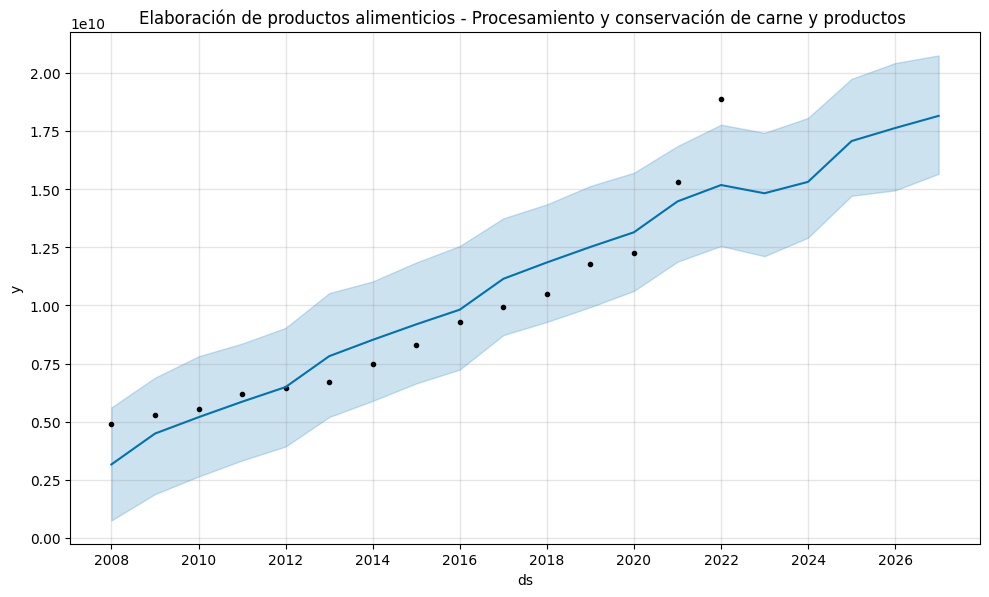

<Figure size 1200x800 with 0 Axes>

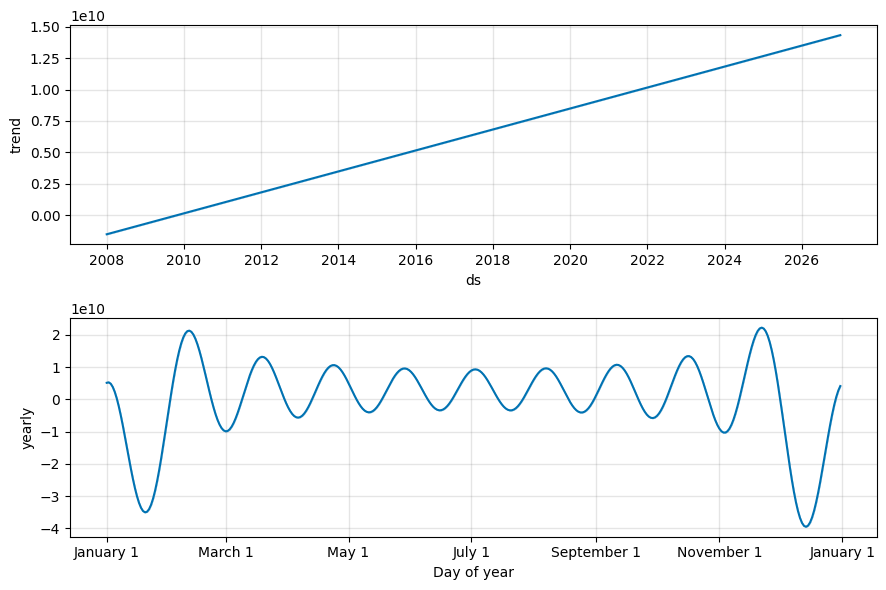


Analisis de crecimiento:
crecimiento promedio por año: 11.04%
Total crecimiento acumulado: 381.05%


In [47]:
row_data = df.iloc[0]
title = f"{row_data['Subsector']} - {row_data['Descripción CIIU Rev. 4'][:50]}"
forecast = analyze_row(row_data, title)

actual_values = prepare_prophet_data(row_data)['y'].values
predicted_values = forecast['yhat'][:len(actual_values)].values


print("\nAnalisis de crecimiento:")
print(f"crecimiento promedio por año: {((predicted_values[-1]/predicted_values[0])**(1/len(predicted_values))-1)*100:.2f}%")
print(f"Total crecimiento acumulado: {((predicted_values[-1]/predicted_values[0])-1)*100:.2f}%")


Analizando sector por código CIIU:


12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing



Prediccion para Elaboración de productos alimenticios - Procesamiento y conservación de carne y productos :
           ds          yhat    yhat_lower    yhat_upper
15 2022-12-31  1.483127e+10  1.221478e+10  1.741368e+10
16 2023-12-31  1.532103e+10  1.264154e+10  1.784431e+10
17 2024-12-31  1.707994e+10  1.452887e+10  1.976956e+10
18 2025-12-31  1.763965e+10  1.509340e+10  2.017516e+10
19 2026-12-31  1.816415e+10  1.564725e+10  2.085902e+10


<Figure size 1200x600 with 0 Axes>

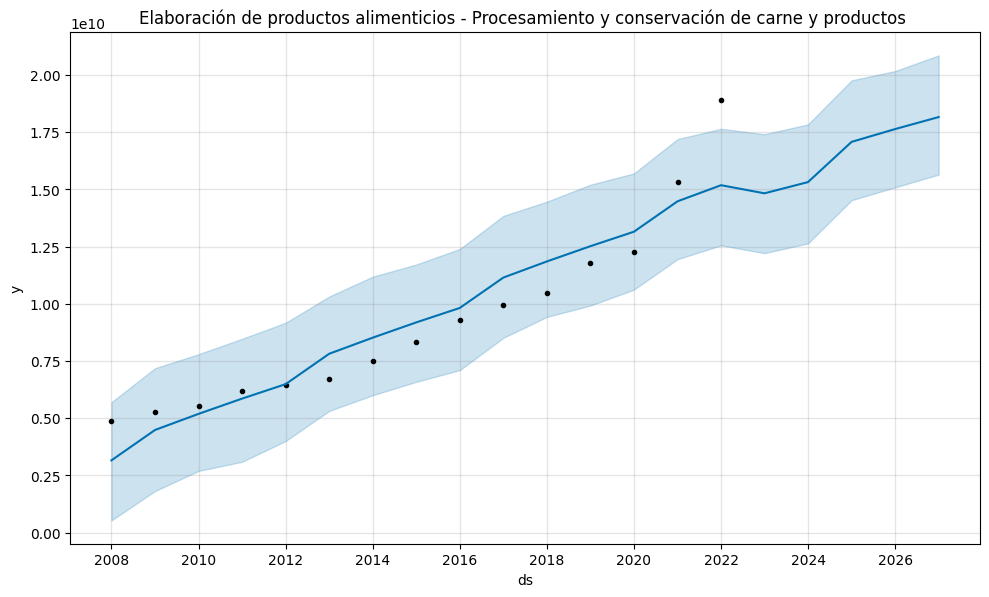

<Figure size 1200x800 with 0 Axes>

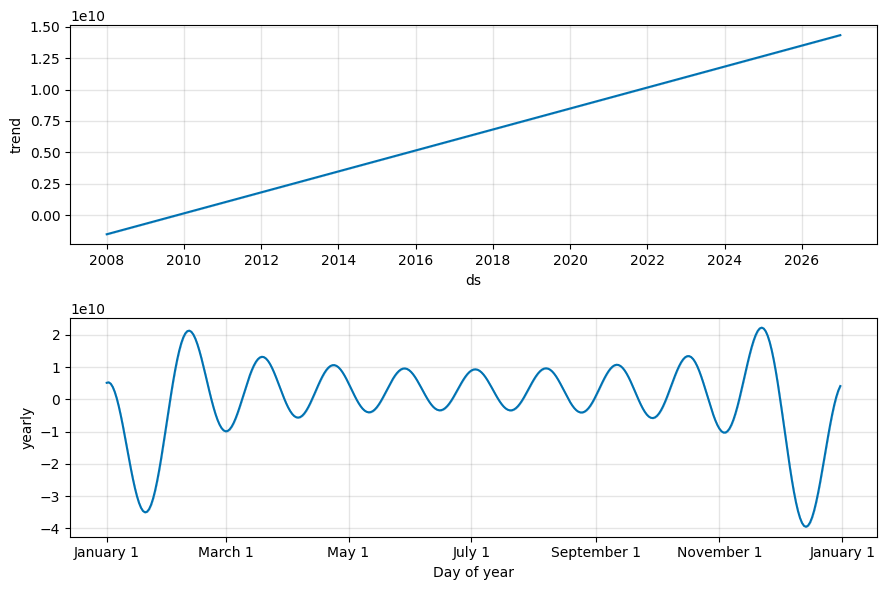


Analisis de crecimiento:
crecimiento promedio por año: 11.04%
Total crecimiento acumulado: 381.05%


In [48]:
def prepare_prophet_data(row):
    data = []
    for year in range(2008, 2023):
        if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
            data.append({
                'ds': pd.to_datetime(f'{year}-01-01'),
                'y': float(row[str(year)])
            })
    prophet_df = pd.DataFrame(data)
    return prophet_df

def run_prophet_forecast(df, periods=5):
    model = Prophet(
        yearly_seasonality=True,
        growth='linear',
        interval_width=0.95
    )
    model.fit(df)
    
    future = model.make_future_dataframe(periods=periods, freq='YE')
    forecast = model.predict(future)
    
    return model, forecast

def analyze_row(row, title):
    prophet_df = prepare_prophet_data(row)
    
    model, forecast = run_prophet_forecast(prophet_df)
    
    print(f"\nPrediccion para {title}:")
    future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
    print(future_forecast)
    
    plt.figure(figsize=(12, 6))
    fig = model.plot(forecast)
    plt.title(title)
    plt.show()
    
    # Plot components
    plt.figure(figsize=(12, 8))
    fig = model.plot_components(forecast)
    plt.show()
    
    return forecast

def analyze_sector(df, sector_index=None, sector_name=None, ciiu_code=None):
    try:
        # Seleccionar el sector según el criterio proporcionado
        if sector_index is not None:
            row_data = df.iloc[sector_index]
        elif sector_name is not None:
            row_data = df[df['Descripción CIIU Rev. 4'] == sector_name].iloc[0]
        elif ciiu_code is not None:
            row_data = df[df['CIIU Rev. 4'].astype(str) == str(ciiu_code)].iloc[0]
        else:
            raise ValueError("Debe proporcionar un criterio de selección")

        # Crear título para el sector
        title = f"{row_data['Subsector']} - {row_data['Descripción CIIU Rev. 4'][:50]}"
        
        # Realizar análisis
        forecast = analyze_row(row_data, title)
        
        # Calcular métricas de crecimiento
        actual_values = prepare_prophet_data(row_data)['y'].values
        predicted_values = forecast['yhat'][:len(actual_values)].values
        
        print("\nAnalisis de crecimiento:")
        print(f"crecimiento promedio por año: {((predicted_values[-1]/predicted_values[0])**(1/len(predicted_values))-1)*100:.2f}%")
        print(f"Total crecimiento acumulado: {((predicted_values[-1]/predicted_values[0])-1)*100:.2f}%")
        
    except Exception as e:
        print(f"Error al analizar el sector: {str(e)}")

def analyze_multiple_sectors(df, indices=None, names=None, codes=None):
    """
    Analiza múltiples sectores basados en una lista de índices, nombres o códigos CIIU
    """
    if indices:
        for idx in indices:
            print(f"\nAnalizando sector índice {idx}")
            analyze_sector(df, sector_index=idx)
    
    if names:
        for name in names:
            print(f"\nAnalizando sector {name}")
            analyze_sector(df, sector_name=name)
    
    if codes:
        for code in codes:
            print(f"\nAnalizando sector código {code}")
            analyze_sector(df, ciiu_code=code)

# Ejemplos de uso:

# 1. Analizar un sector específico por índice
#print("Analizando sector específico por índice:")
#analyze_sector(df, sector_index=0)

# 2. Analizar un sector por nombre
#print("\nAnalizando sector por nombre:")
#analyze_sector(df, sector_name='Procesamiento y conservación de carne y productos cárnicos')

#3. Analizar un sector por código CIIU
print("\nAnalizando sector por código CIIU:")
analyze_sector(df, ciiu_code='1011')

# 4. Analizar múltiples sectores
#print("\nAnalizando múltiples sectores:")
#analyze_multiple_sectors(
#    df,
#    indices=[0, 1, 2],  # Primeros tres sectores
#    codes=['1011', '1012', '1020'],  # Sectores específicos por código
#    names=['Procesamiento y conservación de carne y productos cárnicos']
#)

# 5. Analizar todos los sectores
#print("\nAnalizando todos los sectores:")
#for index in range(len(df)):
#    analyze_sector(df, sector_index=index)

##añadir RNN al juego

12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 - cmdstanpy - INFO - Chain [1] done processing
d:\Proyectos\hackaton_talentotech_keydata\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


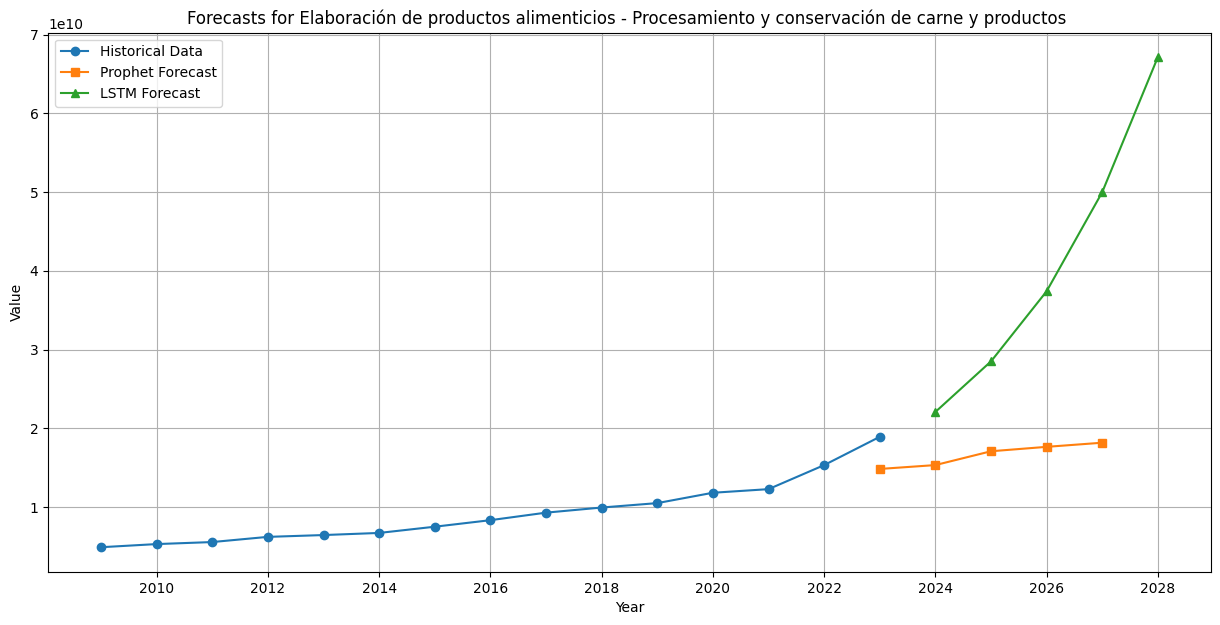

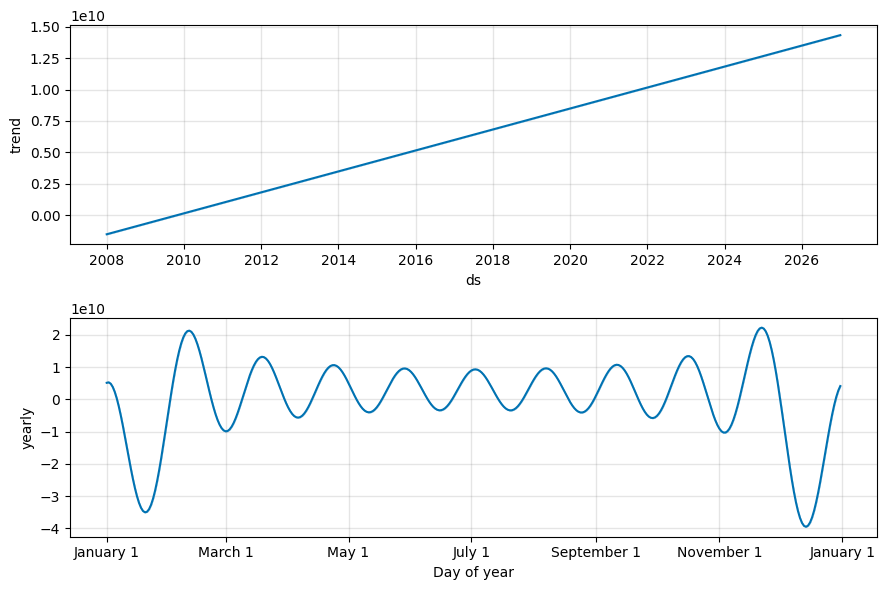


Metricas de rendimiento:
Prophet RMSE: 2,664,156,706.75
Prophet MAPE: 22.53%
LSTM RMSE: 732,905,762.30
LSTM MAPE: 5.00%

Prediccion siguientes 5 años:

Prediccion Prophet:
           ds          yhat    yhat_lower    yhat_upper
15 2022-12-31  1.483127e+10  1.311625e+10  1.651293e+10
16 2023-12-31  1.532103e+10  1.367331e+10  1.699883e+10
17 2024-12-31  1.707994e+10  1.529979e+10  1.871188e+10
18 2025-12-31  1.763965e+10  1.591548e+10  1.934782e+10
19 2026-12-31  1.816415e+10  1.645991e+10  1.980629e+10

Prediccion LSTM:
       Fecha    Prediccion
0 2023-12-31  2.206297e+10
1 2024-12-31  2.850482e+10
2 2025-12-31  3.740844e+10
3 2026-12-31  4.999724e+10
4 2027-12-31  6.714503e+10


In [49]:

class CombinedForecaster:
    def __init__(self, look_back=3):
        self.look_back = look_back
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.prophet_model = None
        self.lstm_model = None
        
    def create_lstm_dataset(self, dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            dataX.append(dataset[i:(i + look_back)])
            dataY.append(dataset[i + look_back])
        return np.array(dataX), np.array(dataY)
    
    def prepare_prophet_data(self, row):
        data = []
        for year in range(2008, 2023):
            if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
                data.append({
                    'ds': pd.to_datetime(f'{year}-01-01'),
                    'y': float(row[str(year)])
                })
        return pd.DataFrame(data)
    
    def prepare_lstm_data(self, row):
        values = []
        for year in range(2008, 2023):
            if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
                values.append(float(row[str(year)]))
        return np.array(values)
    
    def fit_predict(self, row, forecast_periods=5):
        try:
            # Prophet
            prophet_df = self.prepare_prophet_data(row)
            
            # Fit Prophet model
            self.prophet_model = Prophet(yearly_seasonality=True, growth='linear')
            self.prophet_model.fit(prophet_df)
            
            # Make Prophet forecast
            future_dates = self.prophet_model.make_future_dataframe(periods=forecast_periods, freq='YE')
            prophet_forecast = self.prophet_model.predict(future_dates)
            
            # LSTM
            values = self.prepare_lstm_data(row)
            scaled_values = self.scaler.fit_transform(values.reshape(-1, 1))
            
            # Prepare LSTM data
            X, y = self.create_lstm_dataset(scaled_values, self.look_back)
            X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
            
            # Create and fit LSTM model
            self.lstm_model = Sequential([
                LSTM(50, input_shape=(1, self.look_back)),
                Dropout(0.2),
                Dense(1)
            ])
            self.lstm_model.compile(optimizer='adam', loss='mse')
            self.lstm_model.fit(X, y, epochs=100, batch_size=1, verbose=0)
            
            # Make LSTM predictions
            lstm_predictions = []
            current_batch = scaled_values[-self.look_back:]
            
            for i in range(forecast_periods):
                current_batch_reshaped = current_batch.reshape((1, 1, self.look_back))
                next_pred = self.lstm_model.predict(current_batch_reshaped, verbose=0)
                lstm_predictions.append(next_pred[0, 0])
                current_batch = np.roll(current_batch, -1)
                current_batch[-1] = next_pred
                
            # Inverse transform predictions
            lstm_predictions = self.scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))
            
            return prophet_forecast, lstm_predictions
        
        except Exception as e:
            print(f"Error in fit_predict: {str(e)}")
            return None, None
    
    def plot_results(self, row, prophet_forecast, lstm_predictions, title):
        try:
            plt.figure(figsize=(15, 7))
            
            # Plot historical data
            historical_values = self.prepare_lstm_data(row)
            historical_dates = pd.date_range(start='2008-01-01', periods=len(historical_values), freq='YE')
            plt.plot(historical_dates, historical_values, label='Historical Data', marker='o')
            
            # Plot Prophet forecast
            prophet_dates = prophet_forecast['ds'].values[-5:]
            prophet_values = prophet_forecast['yhat'].values[-5:]
            plt.plot(prophet_dates, prophet_values, label='Prophet Forecast', marker='s')
            
            # Plot LSTM forecast
            lstm_dates = pd.date_range(start=historical_dates[-1], periods=6, freq='YE')[1:]
            plt.plot(lstm_dates, lstm_predictions, label='LSTM Forecast', marker='^')
            
            plt.title(f'Forecasts for {title}')
            plt.xlabel('Year')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Plot Prophet components
            self.prophet_model.plot_components(prophet_forecast)
            plt.show()
            
        except Exception as e:
            print(f"Error in plot_results: {str(e)}")
    
    def calculate_metrics(self, actual_values, prophet_forecast, lstm_predictions):
        try:
            # Prepare actual values for comparison
            actual_values = actual_values[self.look_back:]
            
            # Calculate Prophet metrics
            prophet_predictions = prophet_forecast['yhat'][:len(actual_values)]
            prophet_rmse = math.sqrt(mean_squared_error(actual_values, prophet_predictions))
            prophet_mape = mean_absolute_percentage_error(actual_values, prophet_predictions) * 100
            
            # Calculate LSTM metrics
            scaled_actual = self.scaler.transform(actual_values.reshape(-1, 1))
            X_train, y_train = self.create_lstm_dataset(scaled_actual, self.look_back)
            X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            
            lstm_pred_train = self.lstm_model.predict(X_train, verbose=0)
            lstm_pred_train = self.scaler.inverse_transform(lstm_pred_train)
            
            # Align the arrays for comparison
            y_train_actual = actual_values[self.look_back:len(lstm_pred_train) + self.look_back]
            
            lstm_rmse = math.sqrt(mean_squared_error(y_train_actual, lstm_pred_train))
            lstm_mape = mean_absolute_percentage_error(y_train_actual, lstm_pred_train) * 100
            
            return {
                'prophet_rmse': prophet_rmse,
                'prophet_mape': prophet_mape,
                'lstm_rmse': lstm_rmse,
                'lstm_mape': lstm_mape
            }
            
        except Exception as e:
            print(f"Error in calculate_metrics: {str(e)}")
            return None

def analyze_row(df, row_index):
    try:
        row = df.iloc[row_index]
        title = f"{row['Subsector']} - {row['Descripción CIIU Rev. 4'][:50]}"
        
        forecaster = CombinedForecaster(look_back=3)
        prophet_forecast, lstm_predictions = forecaster.fit_predict(row)
        
        if prophet_forecast is not None and lstm_predictions is not None:
            # Plot results
            forecaster.plot_results(row, prophet_forecast, lstm_predictions, title)
            
            # Calculate and print metrics
            actual_values = forecaster.prepare_lstm_data(row)
            metrics = forecaster.calculate_metrics(actual_values, prophet_forecast, lstm_predictions)
            
            if metrics:
                print("\nMetricas de rendimiento:")
                print(f"Prophet RMSE: {metrics['prophet_rmse']:,.2f}")
                print(f"Prophet MAPE: {metrics['prophet_mape']:.2f}%")
                print(f"LSTM RMSE: {metrics['lstm_rmse']:,.2f}")
                print(f"LSTM MAPE: {metrics['lstm_mape']:.2f}%")
            
            print("\nPrediccion siguientes 5 años:")
            print("\nPrediccion Prophet:")
            print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
            print("\nPrediccion LSTM:")
            future_dates = pd.date_range(start='2023-01-01', periods=5, freq='YE')
            lstm_df = pd.DataFrame({
                'Fecha': future_dates,
                'Prediccion': lstm_predictions.flatten()
            })
            print(lstm_df)
            
            return prophet_forecast, lstm_predictions
        else:
            print("Error: Modelos fallidos")
            return None, None
            
    except Exception as e:
        print(f"Error analizando columna: {str(e)}")
        return None, None

# Analyze the first row
prophet_forecast, lstm_predictions = analyze_row(df, 0)

#Creando a Lukita

In [50]:
def cargar_api_key(archivo='D:\\Proyectos\\hackaton_talentotech_keydata\\keys\\googleKey.txt'):
    with open(archivo, 'r') as f:
        lineas = f.readlines()
        for linea in lineas:
            if linea.startswith('API_KEY'):
                return linea.split('=')[1].strip()  # Devuelve la clave sin espacios

api_key = cargar_api_key()


In [51]:
GOOGLE_API_KEY=api_key

import google.generativeai as genai
genai.configure(api_key=GOOGLE_API_KEY)
model=genai.GenerativeModel('gemini-1.5-flash')
response = model.generate_content("Hola, explicame el ipc en colombia, y que signfica esta prediccion en ventas para el sector carnico:         Date      Forecast0 2023-12-31  2.131281e+101 2024-12-31  2.686115e+102 2025-12-31  3.427003e+103 2026-12-31  4.391953e+104 2027-12-31  5.730523e+10 ")

print(response.text)

## IPC en Colombia y Predicción de Ventas del Sector Cárnico

### IPC en Colombia

El **IPC (Índice de Precios al Consumidor)** en Colombia es una medida que refleja la variación en el precio de una canasta de bienes y servicios que consumen las familias. 

* **Cómo funciona:** Se calcula tomando un periodo base como referencia (100) y comparando el costo de la canasta de bienes y servicios en el periodo actual con ese periodo base. Si el IPC es mayor a 100, significa que los precios han aumentado. 
* **Importancia:** Es un indicador clave de la inflación, que a su vez afecta el poder adquisitivo de las personas y la rentabilidad de las empresas.

### Predicción de Ventas del Sector Cárnico

La predicción de ventas que mencionas para el sector cárnico parece tener un error. Los números presentados son extremadamente grandes (en la escala de 10 elevado a la potencia de 101, 102, etc.). Esto sugiere que los datos no están correctamente formateados o hay un error en el modelo de predicció

In [52]:
GOOGLE_API_KEY = api_key



# Configurar la API
genai.configure(api_key=GOOGLE_API_KEY)

# Especificar el modelo a usar
model = genai.GenerativeModel('gemini-pro')  # Usar Gemini Pro

# Crear los datos de predicción
future_dates = pd.date_range(start="2023-12-31", periods=5, freq="YE")
lstm_predictions = [2.13e10, 2.68e11, 3.42e12, 4.39e13, 5.73e14]

# Crear DataFrame inicial
lstm_df = pd.DataFrame({
    'Fecha': future_dates,
    'Predicción': lstm_predictions
})

# Crear el texto de predicciones
predictions_text = "\n".join([f"{row['Fecha'].date()}: {row['Predicción']:.2e}" 
                            for _, row in lstm_df.iterrows()])

# Tu prompt original
prompt = f"""
Eres Lukita, una asistente virtual amigable que explica a empresarios sin conocimientos técnicos sobre modelos de predicción económica.
Vas a analizar las predicciones en la variable 'lstm_predictions', que muestra estimaciones anuales para los próximos 5 años de ventas en el sector cárnico.
Debes detallar cómo interpretar las cifras en términos de tendencias de crecimiento o cambios, explicar brevemente qué significa el modelo LSTM
y cómo podría ayudar al negocio a tomar decisiones estratégicas.

Estos son los valores predichos por el modelo LSTM para los próximos 5 años (en miles de millones):
{predictions_text}

Proporciona la explicación en lenguaje claro y útil para alguien sin conocimientos previos en análisis de datos.
"""

# Generar respuesta
response = model.generate_content(prompt)

# Crear un DataFrame con la respuesta
lstm_df['Análisis'] = response.text.split('\n\n')[0]  # Tomar el primer párrafo como análisis
print(lstm_df)

       Fecha    Predicción                           Análisis
0 2023-12-31  2.130000e+10  **¡Hola, encantado de ayudarte!**
1 2024-12-31  2.680000e+11  **¡Hola, encantado de ayudarte!**
2 2025-12-31  3.420000e+12  **¡Hola, encantado de ayudarte!**
3 2026-12-31  4.390000e+13  **¡Hola, encantado de ayudarte!**
4 2027-12-31  5.730000e+14  **¡Hola, encantado de ayudarte!**


In [54]:
lstm_df.to_csv('predicciones_lstm.csv')